In [1]:
# default_exp capture

In [2]:
#hide

import sys
sys.executable
sys.path
%cd ..

/Users/eway/Desktop/openhsi


# Capture Support and Simulated Cameras

> The bridge between camera implementations and the rest of `openhsi` land.



> Tip: This module can be imported using `from openhsi.capture import *`


The OpenHSI class defines the interface between custom camera implementations and all the processing and calibration needed to run a pushbroom hyperspectral imager. 

In [3]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [4]:
#export
#hide_output

from fastcore.foundation import patch
from fastcore.meta import delegates
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from PIL import Image
from tqdm import tqdm
import warnings

from typing import Iterable, Union, Callable, List, TypeVar, Generic, Tuple, Optional
import json
import pickle

In [5]:
#export
from openhsi.data import *

In [6]:
#export
#hide

# numpy.ndarray type hints
Shape = TypeVar("Shape"); DType = TypeVar("DType")
class Array(np.ndarray, Generic[Shape, DType]):
    """  
    Use this to type-annotate numpy arrays, e.g. 
        image: Array['H,W,3', np.uint8]
        xy_points: Array['N,2', float]
        nd_mask: Array['...', bool]
    from: https://stackoverflow.com/questions/35673895/type-hinting-annotation-pep-484-for-numpy-ndarray
    """
    pass

In [7]:
#export

@delegates()
class OpenHSI(DataCube):
    """Base Class for the OpenHSI Camera."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        super().set_processing_lvl(self.proc_lvl)
        if callable(getattr(self,"get_temp",None)):
            self.cam_temperatures = CircArrayBuffer(size=(self.n_lines,),dtype=np.float32)
        
    def __enter__(self):
        return self
    
    def __close__(self):
        self.stop_cam()

    def __exit__(self, exc_type, exc_value, traceback):
        self.stop_cam()
        
    def collect(self):
        """Collect the hyperspectral datacube."""
        self.start_cam()
        for i in tqdm(range(self.n_lines)):
            self.put(self.get_img())
            
            if callable(getattr(self,"get_temp",None)):
                self.cam_temperatures.put( self.get_temp() )
        self.stop_cam()
        
    def avgNimgs(self, n) -> np.ndarray:
        """Take `n` images and find the average"""
        data = np.zeros(tuple(self.settings['resolution'])+(n,),np.int32)
        
        self.start_cam()
        for f in range(n):
            data[:,:,f]=self.get_img()
        self.stop_cam()
        return np.mean(data,axis=2)


In [8]:
show_doc(OpenHSI.collect)
show_doc(OpenHSI.avgNimgs)

<h4 id="OpenHSI.collect" class="doc_header"><code>OpenHSI.collect</code><a href="__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>OpenHSI.collect</code>()

```
Collect the hyperspectral datacube.
```

<h4 id="OpenHSI.avgNimgs" class="doc_header"><code>OpenHSI.avgNimgs</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>OpenHSI.avgNimgs</code>(**`n`**)

```
Take `n` images and find the average
```

> Warning: Running in notebook slow downs the camera more than running in a script. 

To add a custom camera, five methods need to be defined in a class to:
1. Initialise camera `__init__`,  and
2. Open camera `start_cam`, and
3. Close camera `stop_cam`,  and
4. Capture a picture as a numpy array `get_img`, and
5. Update the exposure settings `set_exposure`, and
6. [Optional] Poll the camera temperature `get_temp`.

By inheriting from the `OpenHSI` class, all the methods to load settings/calibration files, collect datacube, saving data to NetCDF, and viewing as RGB are integrated. Furthermore, the custom camera class can be passed to a `SettingsBuilder` class for calibration. 

For example, we implement a simulated camera below. 

In [9]:
# export

@delegates()
class SimulatedCamera(OpenHSI):
    """Simulated camera using an RGB image as an input. Hyperspectral data is produced using CIE XYZ matching functions."""
    def __init__(self, 
                 img_path:str = None, # Path to an RGB image file
                 mode:str = None,     # Default is to generate lines from the RGB image. Other options are `HgAr` and `flat` to simulate the HgAr spectrum and a flat field respectively.
                 **kwargs):
        """Initialise Simulated Camera"""
        super().__init__(**kwargs)
        self.mode = mode
        
        if img_path is None:
            self.img = np.random.randint(0,255,(*self.settings["resolution"],3))
        else:
            with Image.open(img_path) as img:
                img = img.resize((np.shape(img)[1],self.settings["resolution"][0]))
                self.img = np.array(img)[...,:3]
        
        if mode == "HgAr":
            self.gen = self.gen_sim_spectra()
        elif mode == "flat":
            self.gen = self.gen_flat()
        
        self.rgb_buff = CircArrayBuffer(self.img.shape,axis=1,dtype=np.uint8)
        self.rgb_buff.data = self.img
        self.rgb_buff.slots_left = 0 # make buffer full
        
        # Precompute the CIE XYZ matching functions to convert RGB values to a pseudo-spectra
        def piecewise_Guass(x,A,μ,σ1,σ2):
            t = (x-μ) / ( σ1 if x < μ else σ2 )
            return A * np.exp( -(t**2)/2 )
        def wavelength2xyz(λ):
            """λ is in nanometers"""
            λ *= 10 # convert to angstroms for the below formulas
            x̅ = piecewise_Guass(λ,  1.056, 5998, 379, 310) + \
                piecewise_Guass(λ,  0.362, 4420, 160, 267) + \
                piecewise_Guass(λ, -0.065, 5011, 204, 262)
            y̅ = piecewise_Guass(λ,  0.821, 5688, 469, 405) + \
                piecewise_Guass(λ,  0.286, 5309, 163, 311)
            z̅ = piecewise_Guass(λ,  1.217, 4370, 118, 360) + \
                piecewise_Guass(λ,  0.681, 4590, 260, 138)
            return np.array([x̅,y̅,z̅])
        self.λs = np.poly1d( np.polyfit(np.arange(len(self.calibration["wavelengths"])),self.calibration["wavelengths"] ,3) )(
                            np.arange(self.settings["resolution"][1]))
        self.xs = np.zeros( (1,len(self.λs)),dtype=np.float32)
        self.ys = self.xs.copy(); self.zs = self.xs.copy()
        for i in range(len(self.xs[0])):
            self.xs[0,i], self.ys[0,i], self.zs[0,i] = wavelength2xyz(self.λs[i])
        
        self.xyz_buff = CircArrayBuffer(self.settings["resolution"],axis=0,dtype=np.int32)
    
    def mode_change(self,mode:str=None):
        """Switch between simulating HgAr, flat field, or neither."""
        if   mode == "HgAr":
            self.gen = self.gen_sim_spectra()
        elif mode == "flat":
            self.gen = self.gen_flat()
        else:
            self.mode = None
        
    def rgb2xyz_matching_funcs(self, rgb:np.ndarray) -> np.ndarray:
        """convert an RGB value to a pseudo-spectra with the CIE XYZ matching functions."""
        for i in range(rgb.shape[0]):
            self.xyz_buff.put( rgb[i,0]*self.xs + rgb[i,1]*self.ys + rgb[i,2]*self.zs )
        return self.xyz_buff.data

    
    def gen_flat(self):
        """simulated blackbody radiation"""
        T_K = 5800 # K. Sun's blackbody temperature
        # physical constants
        PLANCK_CONSTANT   = 6.62607015e-34 # J.s
        SPEED_OF_LIGHT    = 299_792_458    # m/s
        BOLTZMAN_CONSTANT = 1.38064852e-23 # J/K
        wavelengths = np.linspace(np.min(self.calibration["wavelengths"]),
                                  np.max(self.calibration["wavelengths"]),
                                  num=self.settings["resolution"][1])
        y = (2*PLANCK_CONSTANT*SPEED_OF_LIGHT**2)/(wavelengths*1e-9)**5 / (
                np.exp((PLANCK_CONSTANT*SPEED_OF_LIGHT)/
                       (wavelengths*1e-9*BOLTZMAN_CONSTANT*T_K)) - 1)
        y = np.uint8(255 * y/np.max(y))
        
        img = np.zeros(tuple(self.settings["resolution"]),dtype=np.uint8)
        for i in range(*self.settings["row_slice"]):
            img[i,:] = y
        while True:
            yield img
        
    def gen_sim_spectra(self):
        """simulated picture of a HgAr lamp"""
        lines_nm = [254,436,546,764,405,365,578,750,738,697,812,772,912,801,842,795,706,826,852,727] # approx sorted by emission strength
        img = np.zeros(tuple(self.settings["resolution"]),dtype=np.uint8)
        wavelengths = np.linspace(np.min(self.calibration["wavelengths"]),
                                  np.max(self.calibration["wavelengths"]),
                                  num=self.settings["resolution"][1])
        row_slice = slice(*self.settings["row_slice"])
        
        strength = 255
        for line in lines_nm: 
            indx = np.sum(wavelengths<line)
            if indx > 0 and indx < self.settings["resolution"][1]:
                img[row_slice,indx-2:indx+2] = strength
                strength -= 5
        while True:
            yield img
    
    def start_cam(self):
        pass
    
    def stop_cam(self):
        pass
    
    def get_img(self) -> np.ndarray:
        if self.mode in ("HgAr","flat"):
            return next(self.gen)
        if self.rgb_buff.is_empty():
            self.rgb_buff.slots_left = 0 # make buffer full again
        return self.rgb2xyz_matching_funcs(self.rgb_buff.get())
    
    def set_exposure(self):
        pass

    def get_temp(self):
        return 20.


In [10]:
show_doc(SimulatedCamera.mode_change)
show_doc(SimulatedCamera.rgb2xyz_matching_funcs)


<h4 id="SimulatedCamera.mode_change" class="doc_header"><code>SimulatedCamera.mode_change</code><a href="__main__.py#L54" class="source_link" style="float:right">[source]</a></h4>

> <code>SimulatedCamera.mode_change</code>(**`mode`**:`str`=*`None`*)

```
Switch between simulating HgAr, flat field, or neither.
```

<h4 id="SimulatedCamera.rgb2xyz_matching_funcs" class="doc_header"><code>SimulatedCamera.rgb2xyz_matching_funcs</code><a href="__main__.py#L63" class="source_link" style="float:right">[source]</a></h4>

> <code>SimulatedCamera.rgb2xyz_matching_funcs</code>(**`rgb`**:`ndarray`)

```
convert an RGB value to a pseudo-spectra with the CIE XYZ matching functions.
```

In [11]:
with SimulatedCamera(img_path="assets/great_hall_slide.png", n_lines=1024, processing_lvl = 2, 
                     json_path="assets/cam_settings.json",pkl_path="assets/cam_calibration.pkl") as cam:
    cam.collect()
    fig = cam.show(plot_lib="matplotlib",hist_eq=True)


Allocated 480.78 MB of RAM. There was 6476.44 MB available.


100%|██████████| 1024/1024 [00:19<00:00, 51.95it/s]


:RGB   [x,y]   (R,G,B)
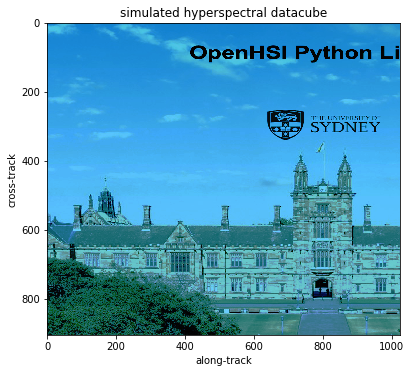

In [12]:
fig.opts(fig_inches=7,title="simulated hyperspectral datacube")

Each RGB value is converted into a pseudo-spectra by using the CIE XYZ matching functions. 

Text(0, 0.5, 'CIE XYZ value')

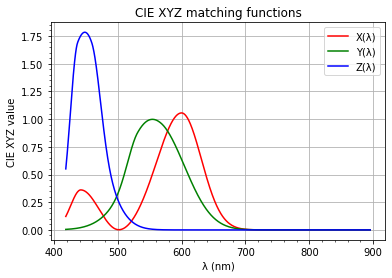

In [13]:
#hide_input
plt.plot(cam.λs,cam.xs[0],'r',label="X(λ)")
plt.plot(cam.λs,cam.ys[0],'g',label="Y(λ)")
plt.plot(cam.λs,cam.zs[0],'b',label="Z(λ)")
plt.grid(); plt.minorticks_on()
plt.title("CIE XYZ matching functions")
plt.legend()
plt.xlabel("λ (nm)")
plt.ylabel("CIE XYZ value")

### Simulated flat field picture

We will use the Sun's blackbody radiation for this.

In [14]:
show_doc(SimulatedCamera.gen_flat)


<h4 id="SimulatedCamera.gen_flat" class="doc_header"><code>SimulatedCamera.gen_flat</code><a href="__main__.py#L70" class="source_link" style="float:right">[source]</a></h4>

> <code>SimulatedCamera.gen_flat</code>()

```
simulated blackbody radiation
```

Allocated 559.45 MB of RAM. There was 6209.59 MB available.


100%|██████████| 128/128 [00:00<00:00, 411.09it/s]


:RGB   [x,y]   (R,G,B)
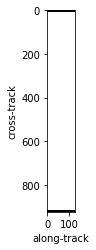

In [15]:
with SimulatedCamera(mode="flat", n_lines=128, processing_lvl = -1, 
                     json_path="assets/cam_settings.json",pkl_path="assets/cam_calibration.pkl",
                     ) as cam:
    cam.collect()
    fig = cam.show(plot_lib="matplotlib")
fig.opts(fig_inches=(1,4))

If we look at each simulated picture as it goes into the datacube, it looks like this a blackbody spectrum along the wavelength axis. There are also top and bottom black bars to simulate the rows that would get illuminated in a real camera. 

Text(0, 0.5, 'cross-track')

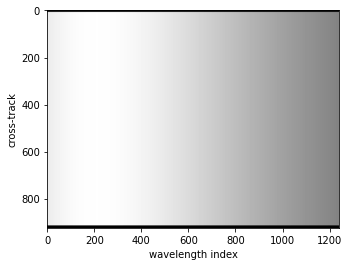

In [16]:
plt.imshow(cam.dc.data[:,0,:], cmap="gray")
plt.xlabel("wavelength index")
plt.ylabel("cross-track")

### Simulated HgAr lamp pic

For testing wavelength calibration.

In [17]:
show_doc(SimulatedCamera.gen_sim_spectra)

<h4 id="SimulatedCamera.gen_sim_spectra" class="doc_header"><code>SimulatedCamera.gen_sim_spectra</code><a href="__main__.py#L91" class="source_link" style="float:right">[source]</a></h4>

> <code>SimulatedCamera.gen_sim_spectra</code>()

```
simulated picture of a HgAr lamp
```

In [18]:
with SimulatedCamera(mode="HgAr", n_lines=128, processing_lvl = -1, 
                     json_path="assets/cam_settings.json",pkl_path="assets/cam_calibration.pkl",
                     ) as cam:
    cam.collect()

Allocated 559.45 MB of RAM. There was 6443.64 MB available.


100%|██████████| 128/128 [00:00<00:00, 432.95it/s]


We can see the emission lines in roughly the spot where a real HgAr spectral line should fall. The intensity of each emission line is also roughly simulated.

Text(0, 0.5, 'cross-track')

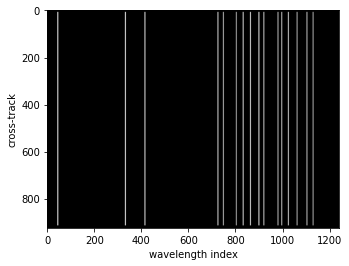

In [19]:
plt.imshow(cam.dc.data[:,0,:], cmap="gray")
plt.xlabel("wavelength index")
plt.ylabel("cross-track")

## Loading and processing datacubes further

> Tip: ProcessRawDatacube only works for raw data captured using `processing_lvl = -1`. 

In [20]:
# export

class ProcessRawDatacube(OpenHSI):
    """Post-process datacubes"""
    def __init__(self, fname:str, processing_lvl:int, json_path:str, pkl_path:str, old_style:bool=False):
        """Post-process datacubes"""
        self.fname = fname
        self.buff = DataCube()
        self.buff.load_nc(fname, old_style=old_style)
        if hasattr(self.buff,"ds_temperatures"):
            self.get_temp = lambda: -999 # this function needs to exist to create temperature buffer
        super().__init__(n_lines=self.buff.dc.data.shape[1], processing_lvl=processing_lvl, json_path=json_path, pkl_path=pkl_path)
    
    def start_cam(self):
        pass
    
    def stop_cam(self):
        pass
    
    def get_img(self) -> np.ndarray:
        return self.buff.dc.get()
    
    def set_exposure(self):
        pass
    
    @delegates(OpenHSI.save)
    def save(self,save_dir:str, **kwargs):
        """Saves to a NetCDF file (and RGB representation) to directory dir_path in folder given by date with file name given by UTC time.
        Override the processing buffer timestamps with the timestamps in original file, also for camera temperatures."""
        self.timestamps.data = self.buff.ds_timestamps
        if hasattr(self.buff,"ds_metadata"):
            self.ds_metadata = self.buff.ds_metadata
        if hasattr(self.buff,"ds_temperatures"):
            self.cam_temperatures.data = self.buff.ds_temperatures
        super().save(save_dir=save_dir, **kwargs)



In [21]:
show_doc(ProcessRawDatacube.save)

<h4 id="ProcessRawDatacube.save" class="doc_header"><code>ProcessRawDatacube.save</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>ProcessRawDatacube.save</code>(**`save_dir`**:`str`, **`preconfig_meta_path`**:`str`=*`None`*, **`prefix`**:`str`=*`''`*, **`suffix`**:`str`=*`''`*)

```
Saves to a NetCDF file (and RGB representation) to directory dir_path in folder given by date with file name given by UTC time.
Override the processing buffer timestamps with the timestamps in original file, also for camera temperatures.
```

```python
json_path = '../calibration_files/OpenHSI-16_settings_Mono8_bin2.json'
pkl_path  = '../calibration_files/OpenHSI-16_calibration_Mono8_bin2_window.pkl'

proc_dc = ProcessRawDatacube(fname = "../../Downloads/16_pvn1_bin2_10ms2022_01_13-04_22_25.nc", processing_lvl=4,
                             json_path=json_path, pkl_path=pkl_path)
proc_dc.collect()

proc_dc.show(hist_eq=True)
```

If your saved datacubes have already been processed (for example, binned for smaller file size), you can further post-process your datacube using `ProcessDatacube`. A list of callable transforms can be provided to `ProcessDatacube.load_next_tfms`, the catch is to remember what transforms have already been applied during data collection and the final desired processing level (binning, radiance output, ...). See the [quick start guide](https://openhsi.github.io/openhsi/tutorial_camera.html) for some documentation on what is done for each processing level. 

> Warning: `next_tfms` needs to be valid. For instance, you cannot bin twice!

In [46]:
#export

@delegates()
class ProcessDatacube(ProcessRawDatacube):
    """Post-process datacubes"""
    def __init__(self, fname:str, processing_lvl:int, json_path:str, pkl_path:str, old_style:bool=False, **kwargs):
        """Post-process datacubes further!"""
        super().__init__(**kwargs)
    
    def load_next_tfms(self, next_tfms:List[Callable[[np.ndarray],np.ndarray]] = []):
        """provide the transforms you want to apply to this dataset"""
        self.tfm_list = next_tfms
        

In [ ]:
show_doc(ProcessDatacube.load_next_tfms)

```python
proced_dc = ProcessDatacube(fname = "../calibration_files/2022_01_13/2022_01_13-04_22_25_proc_lvl_2.nc", processing_lvl=4,
                             json_path=json_path, pkl_path=pkl_path)
proced_dc.load_next_tfms([proced_dc.dn2rad])

proced_dc.collect()

proced_dc.show(hist_eq=True)
```

## Parallel saving of datacubes while simulated camera is continuously running

Saving datacubes is a blocking operation but we want our camera to continue capturing while saving is taking place. This attempts to place the saving in another `multiprocessing.Process` and the underlying datacube is implemented as a shared `multiprocessing.Array`. 

> Warning: Experimental! However, the below example works! I'm a genious. Well, at very least, I feel like one for wrestling with the Global Interpreter Lock and coming out on top. 

In [ ]:
#export
from openhsi.shared import *

In [ ]:
# export

@delegates()
class SharedSimulatedCamera(SharedOpenHSI):
    """Simulated camera using an RGB image as an input. Hyperspectral data is produced using CIE XYZ matching functions."""
    def __init__(self, img_path:str = None, mode:str = None, **kwargs):
        """Initialise Simulated Camera"""
        super().__init__(**kwargs)
        self.mode = mode
        
        if img_path is None:
            self.img = np.random.randint(0,255,(*self.settings["resolution"],3))
        else:
            with Image.open(img_path) as img:
                img = img.resize((np.shape(img)[1],self.settings["resolution"][0]))
                self.img = np.array(img)[...,:3]
        
        if mode == "HgAr":
            self.gen = self.gen_sim_spectra()
        elif mode == "flat":
            self.gen = self.gen_flat()
        
        self.rgb_buff = CircArrayBuffer(self.img.shape,axis=1,dtype=np.uint8)
        self.rgb_buff.data = self.img
        self.rgb_buff.slots_left = 0 # make buffer full
        
        # Precompute the CIE XYZ matching functions to convert RGB values to a pseudo-spectra
        def piecewise_Guass(x,A,μ,σ1,σ2):
            t = (x-μ) / ( σ1 if x < μ else σ2 )
            return A * np.exp( -(t**2)/2 )
        def wavelength2xyz(λ):
            """λ is in nanometers"""
            λ *= 10 # convert to angstroms for the below formulas
            x̅ = piecewise_Guass(λ,  1.056, 5998, 379, 310) + \
                piecewise_Guass(λ,  0.362, 4420, 160, 267) + \
                piecewise_Guass(λ, -0.065, 5011, 204, 262)
            y̅ = piecewise_Guass(λ,  0.821, 5688, 469, 405) + \
                piecewise_Guass(λ,  0.286, 5309, 163, 311)
            z̅ = piecewise_Guass(λ,  1.217, 4370, 118, 360) + \
                piecewise_Guass(λ,  0.681, 4590, 260, 138)
            return np.array([x̅,y̅,z̅])
        self.λs = np.poly1d( np.polyfit(np.arange(len(self.calibration["wavelengths"])),self.calibration["wavelengths"] ,3) )(
                            np.arange(self.settings["resolution"][1]))
        self.xs = np.zeros( (1,len(self.λs)),dtype=np.float32)
        self.ys = self.xs.copy(); self.zs = self.xs.copy()
        for i in range(len(self.xs[0])):
            self.xs[0,i], self.ys[0,i], self.zs[0,i] = wavelength2xyz(self.λs[i])
        
        self.xyz_buff = CircArrayBuffer(self.settings["resolution"],axis=0,dtype=np.int32)
        
    def rgb2xyz_matching_funcs(self, rgb:np.ndarray) -> np.ndarray:
        """convert an RGB value to a pseudo-spectra with the CIE XYZ matching functions."""
        for i in range(rgb.shape[0]):
            self.xyz_buff.put( rgb[i,0]*self.xs + rgb[i,1]*self.ys + rgb[i,2]*self.zs )
        return self.xyz_buff.data

    
    def gen_flat(self):
        """simulated blackbody radiation"""
        T_K = 5800 # K. Sun's blackbody temperature
        # physical constants
        PLANCK_CONSTANT   = 6.62607015e-34 # J.s
        SPEED_OF_LIGHT    = 299_792_458    # m/s
        BOLTZMAN_CONSTANT = 1.38064852e-23 # J/K
        wavelengths = np.linspace(np.min(self.calibration["wavelengths"]),
                                  np.max(self.calibration["wavelengths"]),
                                  num=self.settings["resolution"][1])
        y = (2*PLANCK_CONSTANT*SPEED_OF_LIGHT**2)/(wavelengths*1e-9)**5 / (
                np.exp((PLANCK_CONSTANT*SPEED_OF_LIGHT)/
                       (wavelengths*1e-9*BOLTZMAN_CONSTANT*T_K)) - 1)
        y = np.uint8(255 * y/np.max(y))
        
        img = np.zeros(tuple(self.settings["resolution"]),dtype=np.uint8)
        for i in range(*self.settings["row_slice"]):
            img[i,:] = y
        while True:
            yield img
        
    def gen_sim_spectra(self):
        """simulated picture of a HgAr lamp"""
        lines_nm = [254,436,546,764,405,365,578,750,738,697,812,772,912,801,842,795,706,826,852,727] # approx sorted by emission strength
        img = np.zeros(tuple(self.settings["resolution"]),dtype=np.uint8)
        wavelengths = np.linspace(np.min(self.calibration["wavelengths"]),
                                  np.max(self.calibration["wavelengths"]),
                                  num=self.settings["resolution"][1])
        row_slice = slice(*self.settings["row_slice"])
        
        strength = 255
        for line in lines_nm: 
            indx = np.sum(wavelengths<line)
            if indx > 0 and indx < self.settings["resolution"][1]:
                img[row_slice,indx-2:indx+2] = strength
                strength -= 5
        while True:
            yield img
    
    def start_cam(self):
        pass
    
    def stop_cam(self):
        pass
    
    def get_img(self) -> np.ndarray:
        if self.mode in ("HgAr","flat"):
            return next(self.gen)
        if self.rgb_buff.is_empty():
            self.rgb_buff.slots_left = 0 # make buffer full again
        return self.rgb2xyz_matching_funcs(self.rgb_buff.get())
    
    def set_exposure(self):
        pass

    def get_temp(self):
        return 20.


In [ ]:
#external

num_saved = 0
num2save  = 3

with SharedSimulatedCamera(img_path="assets/great_hall_slide.png", n_lines=128, processing_lvl = 2, 
                     json_path="assets/cam_settings.json",pkl_path="assets/cam_calibration.pkl") as cam:
    
    for i in range(num2save):
        if num_saved > 0:
            #p.join() # waiting for the last process to finish will make this slow. 
            pass
            
        cam.collect()
        print(f"collected from time: {cam.timestamps.data[0]} to {cam.timestamps.data[-1]}")
        p = cam.save("../hyperspectral_snr/temp")
        num_saved += 1
    
    print(f"finished saving {num2save} datacubes")

Due to requiring double the amount of memory and more to facilitate saving in a separate process, make sure your datacubes can fit in your RAM. Have not tested this but I would suggest choosing `n_lines` <= 1/3 the amount used using the regular OpenHSI. 